# Import Libraries

In [1]:
import os
import json
import re
import requests
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create Dataset

## Fetch Topics

In [2]:
WIKI_API_URL = "https://en.wikipedia.org/w/api.php"
TOPICS_FILE = "topics.json"

category_title = "Category:Artificial_intelligence"
all_pages = []
params = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle": category_title,
    "cmlimit": "max"
}

while True:
    response = requests.get(WIKI_API_URL, params=params)
    data = response.json()
    pages = data.get("query", {}).get("categorymembers", [])
    
    for page in pages:
        title = page["title"]
        
        if ":" not in title:
            all_pages.append(title)
    
    if "continue" in data:
        params["cmcontinue"] = data["continue"]["cmcontinue"]
    else:
        break

with open(TOPICS_FILE, "w", encoding="utf-8") as f:
    json.dump(all_pages, f, ensure_ascii=False, indent=4)
    
print(f"Topics have been saved to {TOPICS_FILE}")

Topics have been saved to topics.json


## Fetch Human-written Content

In [3]:
WIKI_API_URL = "https://en.wikipedia.org/w/api.php"
TOPICS_FILE = "topics.json"
HUMAN_FOLDER = "human"
os.makedirs(HUMAN_FOLDER, exist_ok=True)

topics = []

with open(TOPICS_FILE, "r", encoding="utf-8") as f:
    topics = json.load(f) 

updated_topics = []

for topic in tqdm(topics, desc="Fetching", unit="topic"):
    params = {
        "action": "query",
        "format": "json",
        "titles": topic,
        "prop": "extracts",
        "exintro": True,
        "explaintext": True
    }
    response = requests.get(WIKI_API_URL, params=params)
    data = response.json()
    page = next(iter(data["query"]["pages"].values()), None)
    
    if page and "extract" in page:
        content = page["extract"]
        cleaned_topic = re.sub(r'[<>:"/\\|?*]', '', topic)
        filename = os.path.join(HUMAN_FOLDER, f"{cleaned_topic}.txt")
        
        with open(filename, "w", encoding="utf-8") as f:
            f.write(content)
        
        updated_topics.append(topic)

with open(TOPICS_FILE, "w", encoding="utf-8") as f:
    json.dump(updated_topics, f, ensure_ascii=False, indent=4)


Fetching: 100%|██████████| 193/193 [01:24<00:00,  2.28topic/s]


## Generate AI-written Content

In [4]:
OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL = "llama3.2"
TOPICS_FILE = "topics.json"
AI_FOLDER = "ai"
os.makedirs(AI_FOLDER, exist_ok=True)

topics = []

with open(TOPICS_FILE, "r", encoding="utf-8") as f:
    topics = json.load(f)

updated_topics = []

for topic in tqdm(topics, desc="Fetching", unit="topic"):
    content = []
    
    prompt = f"Write an introduction in the style of a Wikipedia article for the topic '{topic}', generating a concise and clear preface using a formal and objective tone. Do not include a title, and only generate the introductory text in pure text form."
    payload = {"model": MODEL, "prompt": prompt, "stream": False}
    response = requests.post(OLLAMA_URL, json=payload)
    
    if response.status_code == 200:
        content = response.json().get("response", "")
        
    if content:
        cleaned_topic = re.sub(r'[<>:"/\\|?*]', '', topic)
        filename = os.path.join(AI_FOLDER, f"{cleaned_topic}.txt")
        
        with open(filename, "w", encoding="utf-8") as f:
            f.write(content)
    
        updated_topics.append(topic)

with open(TOPICS_FILE, "w", encoding="utf-8") as f:
    json.dump(updated_topics, f, ensure_ascii=False, indent=4)


Fetching: 100%|██████████| 193/193 [43:01<00:00, 13.38s/topic]


## Create Dataset

In [5]:
AI_FOLDER = "ai"
HUMAN_FOLDER = "human"
DATASET_FILE = "dataset.csv"

def load_data_from_folder(folder, label):
    data = []
    
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
            cleaned_text = text.replace('\n', ' ').replace('\r', '')
            cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
            data.append({'text': cleaned_text, 'label': label})
    
    return data

human_data = load_data_from_folder(HUMAN_FOLDER, 'human')
ai_data = load_data_from_folder(AI_FOLDER, 'ai')
dataset = pd.DataFrame(human_data + ai_data)
dataset.to_csv(DATASET_FILE, index=False, encoding='utf-8')

print(f"Dataset has been saved to {DATASET_FILE}")

Dataset has been saved to dataset.csv


# Data Preprocessing

## Feature Extraction

In [6]:
def get_bert_features(text):
    encoded = tokenizer(text,
                        add_special_tokens=True,
                        truncation=True,
                        padding=True,
                        max_length=512,
                        return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**encoded)

    cls_vector = outputs.last_hidden_state[0][0].numpy()
    
    return cls_vector


def get_text_features(text):
    vectors = [model.wv[word] for word in text if word in model.wv]

    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * model.vector_size


df = pd.read_csv('dataset.csv')
df['text'] = df['text'].fillna("").astype(str)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
df['bert_vector'] = df['text'].apply(get_bert_features)

df['tokens'] = df['text'].apply(lambda x: word_tokenize(x.lower()))
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
df['word_vector'] = df['tokens'].apply(get_text_features)

## Data Preparing

In [7]:
label_mapping = {
    'human': 0,
    'ai': 1
}

df['label'] = df['label'].map(label_mapping)

X_bert = list(df['bert_vector'])
X_word = list(df['word_vector'])

y = df['label']

# Supervised Learning

## Model Training

### Logistic Regression

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}") 

cv_scores = cross_val_score(model, X_bert, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.9615

Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.9744    0.9620        39
           1     0.9737    0.9487    0.9610        39

    accuracy                         0.9615        78
   macro avg     0.9618    0.9615    0.9615        78
weighted avg     0.9618    0.9615    0.9615        78

Cross-validated accuracy: 0.9715 ± 0.0152


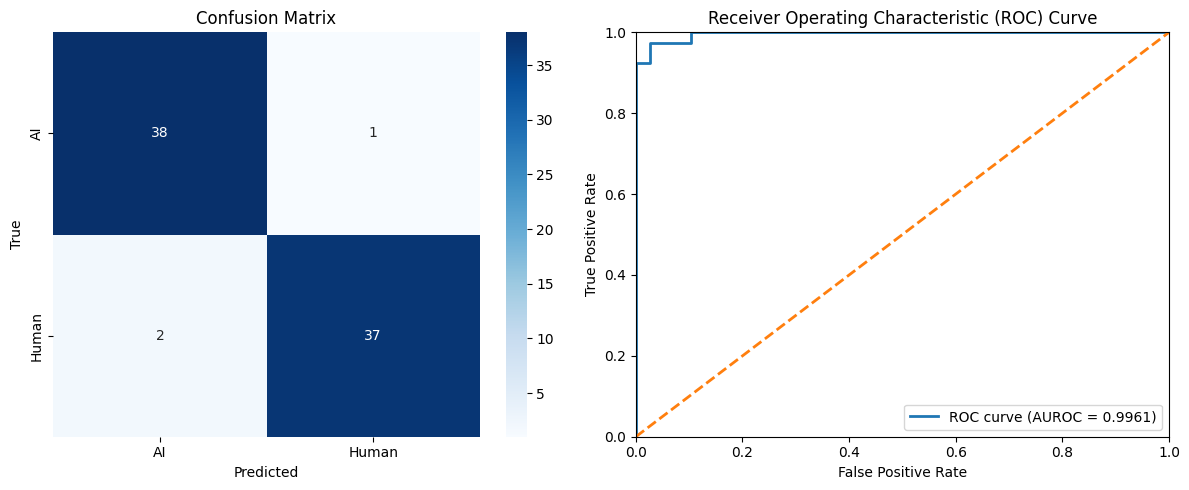

In [9]:
cm = confusion_matrix(y_test, y_pred)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUROC = {auroc:.4f})')
axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


### Support Vector Machine (SVM)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42, stratify=y)

model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}") 

cv_scores = cross_val_score(model, X_bert, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.9615
Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.9744    0.9620        39
           1     0.9737    0.9487    0.9610        39

    accuracy                         0.9615        78
   macro avg     0.9618    0.9615    0.9615        78
weighted avg     0.9618    0.9615    0.9615        78

Cross-validated accuracy: 0.9741 ± 0.0273


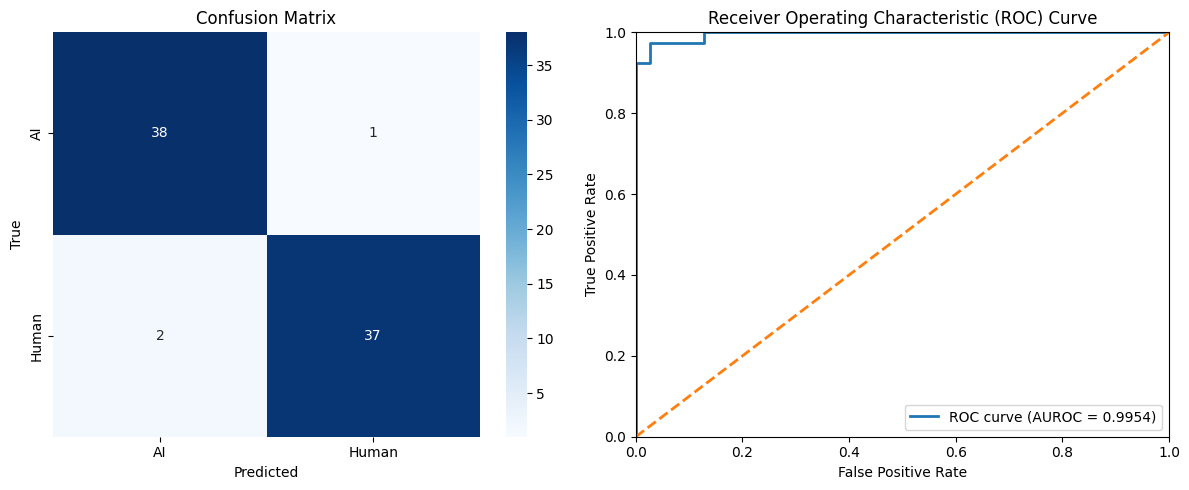

In [11]:
cm = confusion_matrix(y_test, y_pred)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUROC = {auroc:.4f})')
axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


## Feature Engineering

### Logistic Regression

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_word, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}") 

cv_scores = cross_val_score(model, X_word, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.6795
Classification Report:
              precision    recall  f1-score   support

           0     0.6750    0.6923    0.6835        39
           1     0.6842    0.6667    0.6753        39

    accuracy                         0.6795        78
   macro avg     0.6796    0.6795    0.6794        78
weighted avg     0.6796    0.6795    0.6794        78

Cross-validated accuracy: 0.7098 ± 0.0552


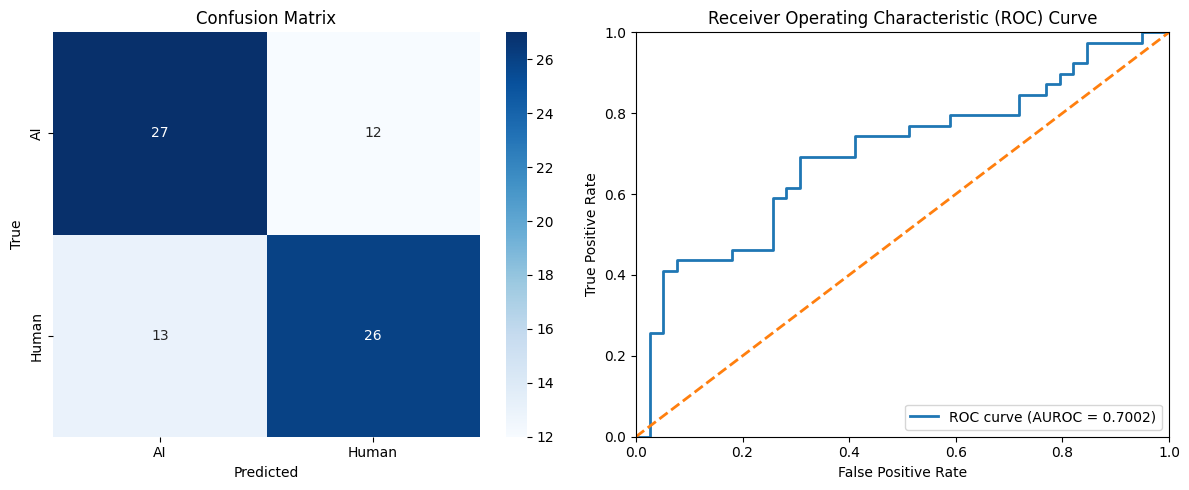

In [13]:
cm = confusion_matrix(y_test, y_pred)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUROC = {auroc:.4f})')
axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

### Support Vector Machine (SVM)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_word, y, test_size=0.2, random_state=42, stratify=y)

model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}") 

cv_scores = cross_val_score(model, X_word, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.6923
Classification Report:
              precision    recall  f1-score   support

           0     0.6923    0.6923    0.6923        39
           1     0.6923    0.6923    0.6923        39

    accuracy                         0.6923        78
   macro avg     0.6923    0.6923    0.6923        78
weighted avg     0.6923    0.6923    0.6923        78

Cross-validated accuracy: 0.7124 ± 0.0556


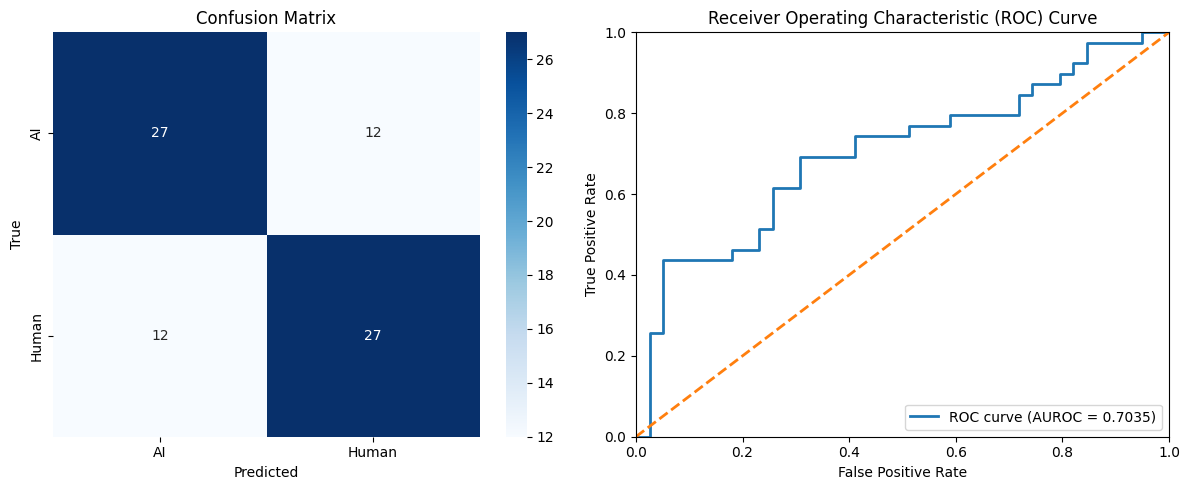

In [15]:
cm = confusion_matrix(y_test, y_pred)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUROC = {auroc:.4f})')
axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## Dataset Split Ratio

### Logistic Regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.4, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}") 

cv_scores = cross_val_score(model, X_bert, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.9419
Classification Report:
              precision    recall  f1-score   support

           0     0.9157    0.9744    0.9441        78
           1     0.9722    0.9091    0.9396        77

    accuracy                         0.9419       155
   macro avg     0.9439    0.9417    0.9418       155
weighted avg     0.9438    0.9419    0.9419       155

Cross-validated accuracy: 0.9715 ± 0.0152


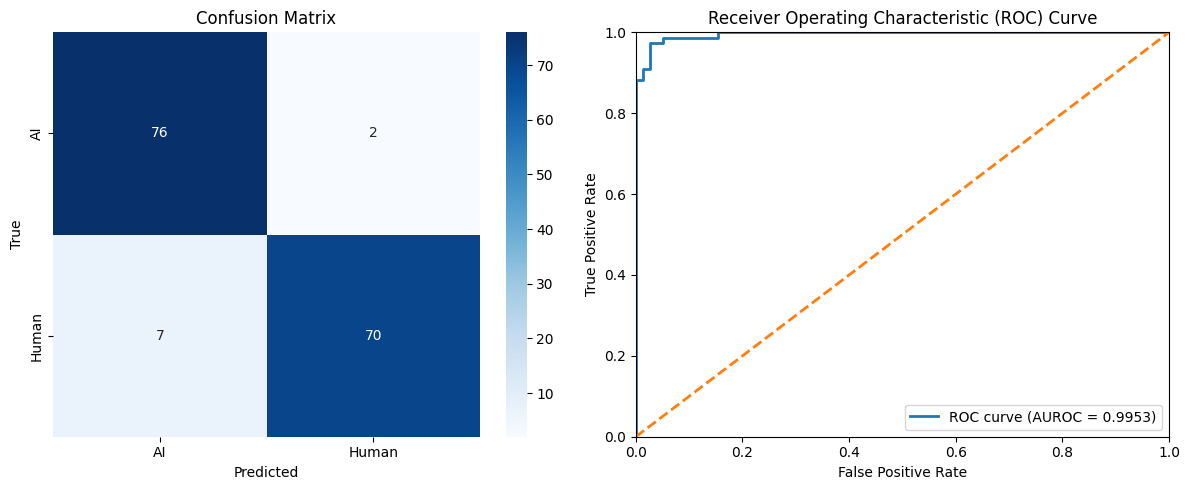

In [17]:
cm = confusion_matrix(y_test, y_pred)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUROC = {auroc:.4f})')
axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

### Support Vector Machine (SVM)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.4, random_state=42, stratify=y)

model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}") 

cv_scores = cross_val_score(model, X_bert, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.9613
Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.9744    0.9620        78
           1     0.9733    0.9481    0.9605        77

    accuracy                         0.9613       155
   macro avg     0.9617    0.9612    0.9613       155
weighted avg     0.9616    0.9613    0.9613       155

Cross-validated accuracy: 0.9741 ± 0.0273


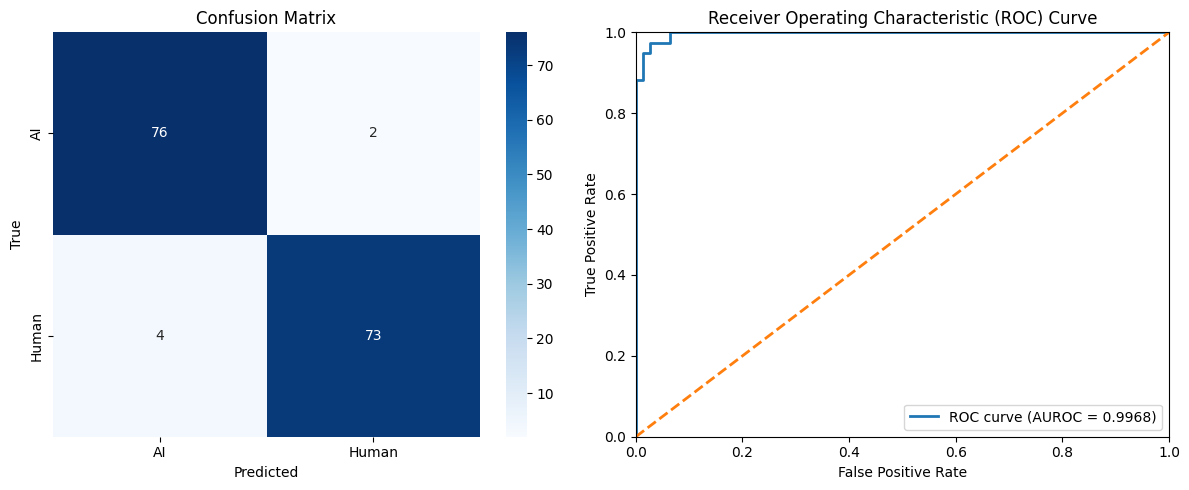

In [19]:
cm = confusion_matrix(y_test, y_pred)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUROC = {auroc:.4f})')
axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Unsupervised Learning

## Model Training

### K-Means Clustering

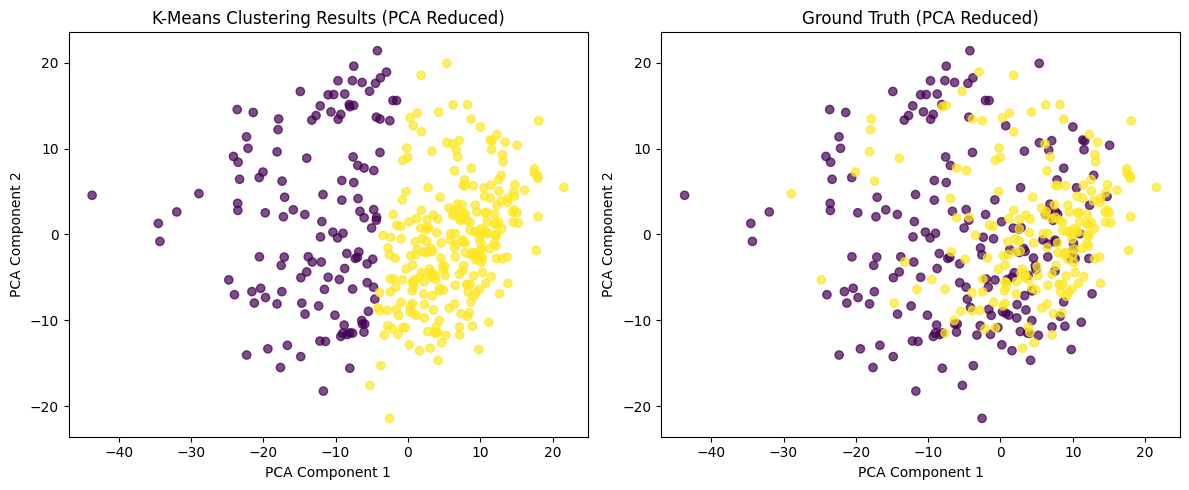

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bert)

model = KMeans(n_clusters=2, random_state=42)
y_pred = model.fit_predict(X_scaled)

reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
axes[0].set_title("K-Means Clustering Results (PCA Reduced)")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

scatter2 = axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1].set_title("Ground Truth (PCA Reduced)")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


In [21]:
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y, y_pred, digits=4)}") 

Accuracy: 0.6813
Classification Report:
              precision    recall  f1-score   support

           0     0.7734    0.5130    0.6168       193
           1     0.6357    0.8497    0.7273       193

    accuracy                         0.6813       386
   macro avg     0.7045    0.6813    0.6720       386
weighted avg     0.7045    0.6813    0.6720       386



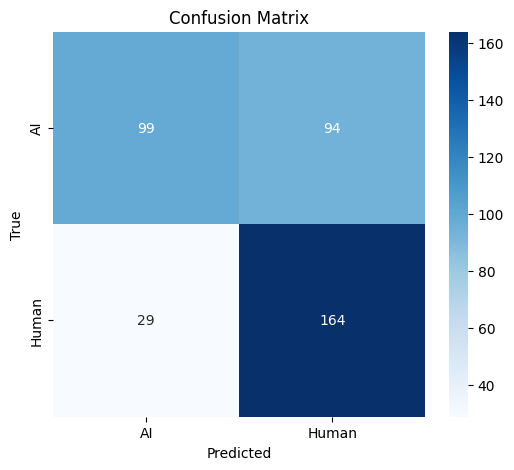

In [22]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Feature Engineering

### K-Means Clustering

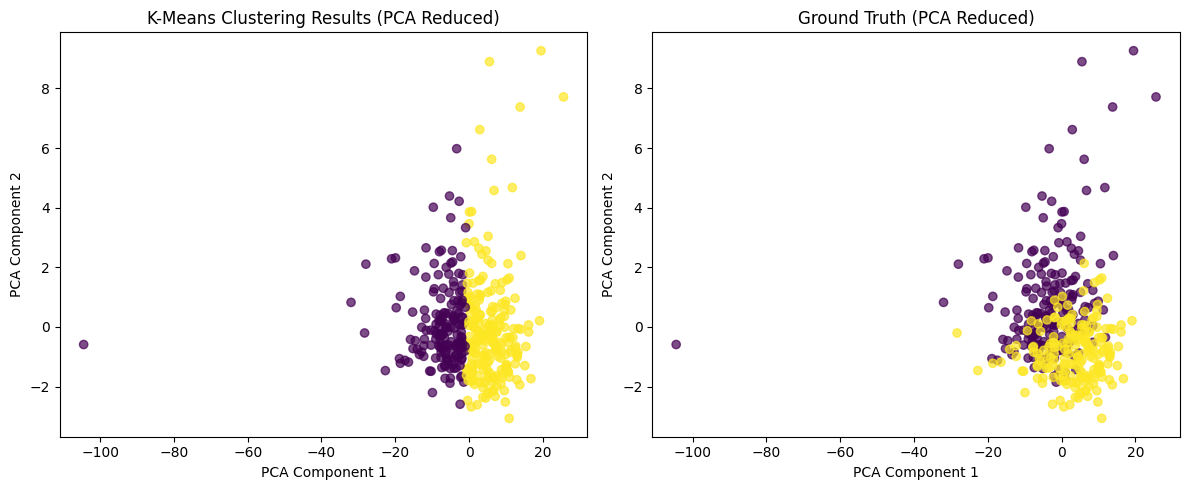

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_word)

model = KMeans(n_clusters=2, random_state=42)
y_pred = model.fit_predict(X_scaled)

reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
axes[0].set_title("K-Means Clustering Results (PCA Reduced)")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

scatter2 = axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1].set_title("Ground Truth (PCA Reduced)")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


In [24]:
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y, y_pred, digits=4)}") 

Accuracy: 0.6839
Classification Report:
              precision    recall  f1-score   support

           0     0.7126    0.6166    0.6611       193
           1     0.6621    0.7513    0.7039       193

    accuracy                         0.6839       386
   macro avg     0.6873    0.6839    0.6825       386
weighted avg     0.6873    0.6839    0.6825       386



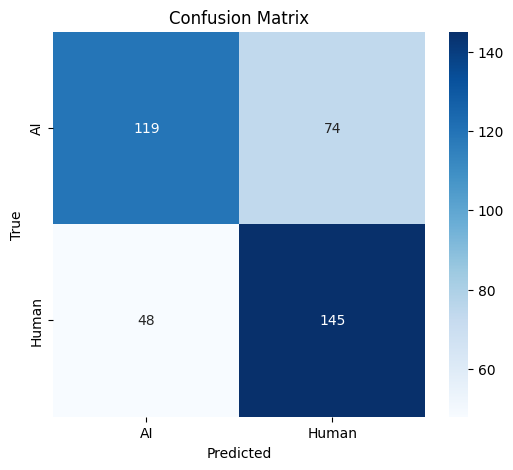

In [25]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Standard Scale

### K-Means Clustering

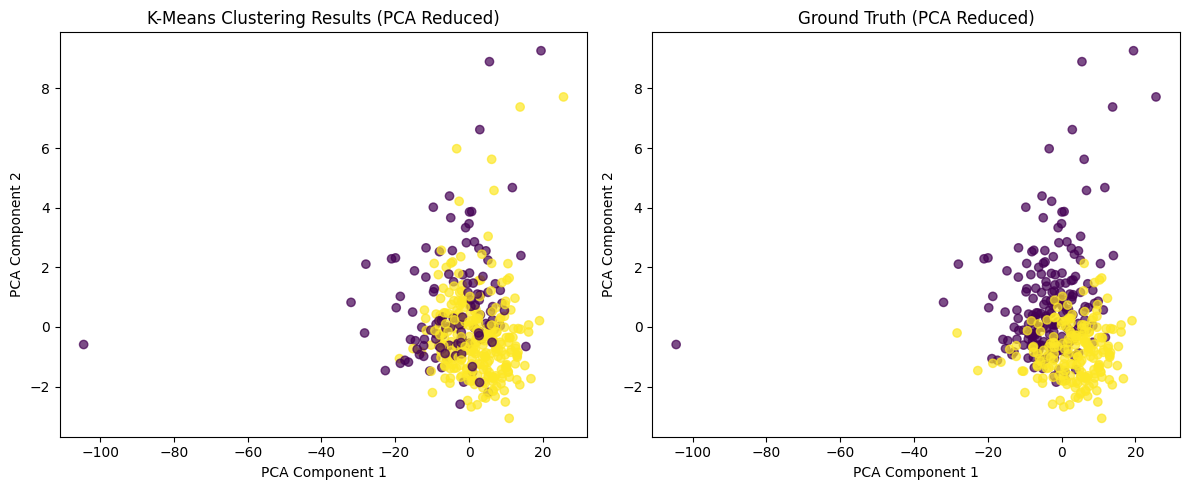

In [26]:
model = KMeans(n_clusters=2, random_state=42)
y_pred = model.fit_predict(X_bert)

reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
axes[0].set_title("K-Means Clustering Results (PCA Reduced)")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

scatter2 = axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1].set_title("Ground Truth (PCA Reduced)")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

In [27]:
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y, y_pred, digits=4)}") 

Accuracy: 0.6580
Classification Report:
              precision    recall  f1-score   support

           0     0.7607    0.4611    0.5742       193
           1     0.6134    0.8549    0.7143       193

    accuracy                         0.6580       386
   macro avg     0.6870    0.6580    0.6442       386
weighted avg     0.6870    0.6580    0.6442       386



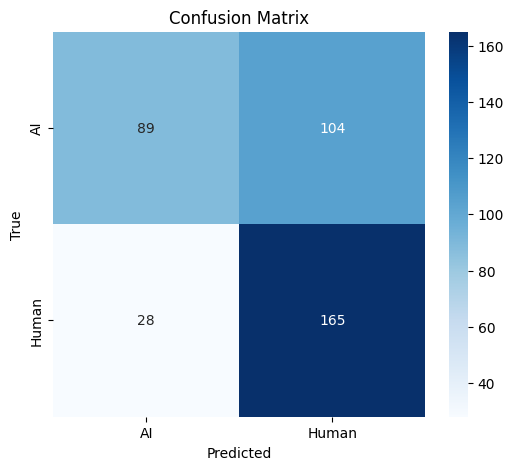

In [28]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()